<a href="https://colab.research.google.com/github/softlighting/hello-algorithm/blob/master/408_Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 8.38 MiB/s, done.
Resolving deltas: 100% (576/576), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdat

In [ ]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2022-12-09 08:46:22--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  10.8MB/s    in 5.9s    

2022-12-09 08:46:29 (8.69 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-12-09 08:46:29--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-12-09 08:46:29--
Total wall clock time: 6.9s
Downloaded: 1 files, 51M in 5.9s (8.69 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

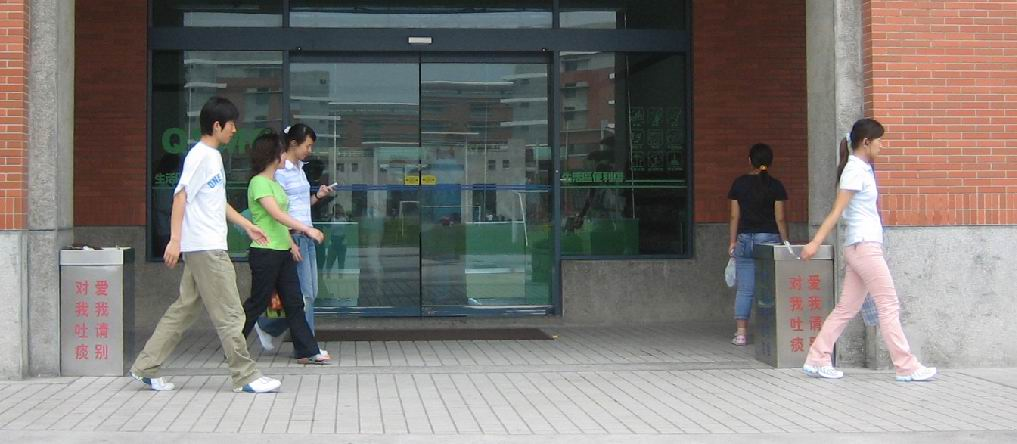

In [ ]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00036.png')

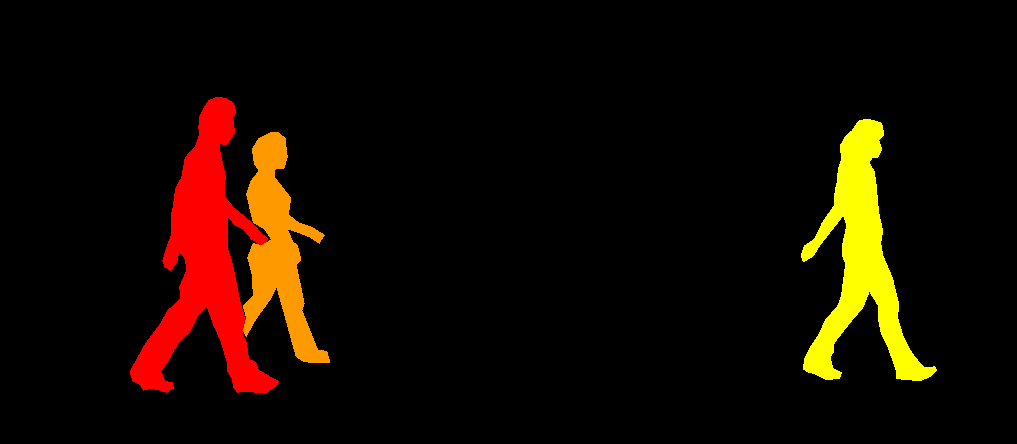

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00036_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FBB212DF460>,
 {'boxes': tensor([[159., 181., 301., 430.],
          [419., 170., 534., 485.]]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([35358., 36225.]),
  'iscrowd': tensor([0, 0])})

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 262895, done.
remote: Counting objects: 100% (2094/2094), done.
remote: Compressing objects: 100% (633/633), done.
remote: Total 262895 (delta 1923), reused 1578 (delta 1457), pack-reused 260801
Receiving objects: 100% (262895/262895), 532.64 MiB | 16.69 MiB/s, done.
Resolving deltas: 100% (239674/239674), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084d8 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:09:24  lr: 0.000090  loss: 2.7899 (2.7899)  loss_classifier: 0.7401 (0.7401)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 9.4098  data: 0.7645  max mem: 2162
Epoch: [0]  [10/60]  eta: 0:01:09  lr: 0.000936  loss: 1.3927 (1.7266)  loss_classifier: 0.5151 (0.4822)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7157 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 1.3834  data: 0.0749  max mem: 3320
Epoch: [0]  [20/60]  eta: 0:00:39  lr: 0.001783  loss: 1.0070 (1.2310)  loss_classifier: 0.2244 (0.3356)  loss_box_reg: 0.2923 (0.2866)  loss_mask: 0.3238 (0.5872)  loss_objectness: 0.0109 (0.0171)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5615  data: 0.0076  max mem: 3320
Epoch: [0]  [30/60]  eta: 0:00:25  lr: 0.002629  loss: 0.5621 (1.0164)  loss_classifier: 0.0990 (0.2558)  loss_box_reg: 0.2663 (0.2869)  loss_mask: 0.1832 (0.4536)  loss_ob

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

[{'boxes': tensor([[ 62.5305,  37.1623, 197.1613, 325.2594],
          [276.5583,  23.7928, 290.8254,  73.7494]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9984, 0.4196], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

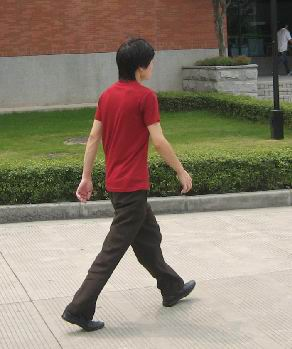

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

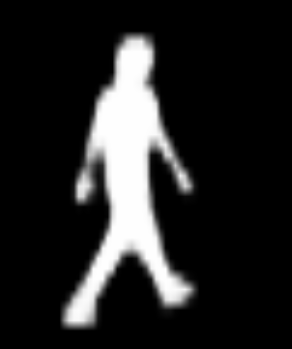

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
from PIL import Image,ImageDraw
import torch
import torchvision
import transforms as T
import os
import numpy as np

In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
def tensor_to_PILImage(tensor):
    unloader=torchvision.transforms.ToPILImage()
    PILImage=tensor.cpu().clone()
    PILImage=PILImage.squeeze(0)
    PILImage=unloader(PILImage)
    return PILImage

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
import utils
import transforms as T


# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model



class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, '\model_mengfan_0005.pkl')

Epoch: [0]  [  0/120]  eta: 0:01:13  lr: 0.000005  loss: 2.7454 (2.7454)  loss_classifier: 0.7775 (0.7775)  loss_box_reg: 0.3232 (0.3232)  loss_mask: 1.5457 (1.5457)  loss_objectness: 0.0957 (0.0957)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 0.6113  data: 0.2819  max mem: 3360
Epoch: [0]  [ 10/120]  eta: 0:00:34  lr: 0.000047  loss: 2.5971 (2.5462)  loss_classifier: 0.7231 (0.7273)  loss_box_reg: 0.3232 (0.3311)  loss_mask: 1.5392 (1.4557)  loss_objectness: 0.0191 (0.0270)  loss_rpn_box_reg: 0.0033 (0.0051)  time: 0.3165  data: 0.0293  max mem: 3360
Epoch: [0]  [ 20/120]  eta: 0:00:30  lr: 0.000089  loss: 1.9112 (2.0245)  loss_classifier: 0.6767 (0.6237)  loss_box_reg: 0.2594 (0.3146)  loss_mask: 0.8781 (1.0559)  loss_objectness: 0.0175 (0.0253)  loss_rpn_box_reg: 0.0033 (0.0051)  time: 0.2898  data: 0.0044  max mem: 3360
Epoch: [0]  [ 30/120]  eta: 0:00:26  lr: 0.000131  loss: 1.1746 (1.6863)  loss_classifier: 0.3567 (0.5102)  loss_box_reg: 0.2852 (0.3226)  loss_mask: 0.4741 (0.8259) 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_test=PennFudanDataset('PennFudanPed',get_transform(train=False))
for i in range(len(dataset_test)):
    img,_ = dataset_test[i]
    model = torch.load('\model_mengfan_0005.pkl')
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        bounding_boxs=prediction[0]['boxes']
        scores=prediction[0]['scores']
        img=tensor_to_PILImage(img)
        for bounding_box,score in zip(bounding_boxs,scores):
            draw=ImageDraw.Draw(img)
            if score>0.90:
                draw.rectangle(xy=(int(bounding_box[0]),int(bounding_box[1]),int(bounding_box[2]),int(bounding_box[3])),fill=None,outline='green',width=2)
                draw.text((int(bounding_box[0])+7,int(bounding_box[1])+7),str(round(float(score),4)),fill=(0,255,0))
            else:
                draw.rectangle(xy=(int(bounding_box[0]), int(bounding_box[1]), int(bounding_box[2]), int(bounding_box[3])),fill=None, outline='red', width=2)
                draw.text((int(bounding_box[0]) + 7, int(bounding_box[1]) + 7), str(round(float(score), 4)),fill=(255, 0, 0))
        img.save('Bounding_img/'+'BOX'+str(i+1)+'.png')

In [ ]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def get_model_instance_segmentation_resnet50(num_classes):
    modelName = 'resnet50'
    print(f'backbone:{modelName}')
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 1024
    print(f"hidden_layer:{hidden_layer}")
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model, modelName

def get_model_instance_segmentation_resnet101(num_classes):
    modelName = 'resnet50'
    print(f'backbone:{modelName}')
    model = torchvision.models.detection.maskrcnn_resnet101_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    print(f"hidden_layer:{hidden_layer}")
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    return model, modelName

def get_model_instance_segmentation_mobilenetv2(num_classes):
    modelName = 'mobilenetv2'
    print(f'backbone:{modelName}')
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.MaskRCNN(backbone=backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    return model, modelName






class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
#modelName = get_model_instance_segmentation_resnet50(num_classes)
model, modelName = get_model_instance_segmentation_mobilenetv2(num_classes)
    # model, modelName = get_model_instance_segmentation_mobilenetv3_small(num_classes)
    # model, modelName = get_model_instance_segmentation_mobilenetv3_large(num_classes)
    # move model to the right device

model.to(device)

backbone:mobilenetv2


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual

In [ ]:

# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model, modelName  = get_model_instance_segmentation_mobilenetv2(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, 'model_mobile2.pkl')

backbone:mobilenetv2
Epoch: [0]  [  0/120]  eta: 0:00:58  lr: 0.000005  loss: 6.0739 (6.0739)  loss_classifier: 0.6546 (0.6546)  loss_box_reg: 0.0296 (0.0296)  loss_mask: 4.6192 (4.6192)  loss_objectness: 0.7420 (0.7420)  loss_rpn_box_reg: 0.0285 (0.0285)  time: 0.4893  data: 0.1903  max mem: 4133
Epoch: [0]  [ 10/120]  eta: 0:00:24  lr: 0.000047  loss: 5.6435 (5.7788)  loss_classifier: 0.6286 (0.6188)  loss_box_reg: 0.0306 (0.0388)  loss_mask: 4.0996 (4.3112)  loss_objectness: 0.7420 (0.7447)  loss_rpn_box_reg: 0.0531 (0.0653)  time: 0.2259  data: 0.0217  max mem: 4945
Epoch: [0]  [ 20/120]  eta: 0:00:21  lr: 0.000089  loss: 4.7031 (4.9631)  loss_classifier: 0.5164 (0.5035)  loss_box_reg: 0.0306 (0.0326)  loss_mask: 3.3588 (3.6327)  loss_objectness: 0.7332 (0.7344)  loss_rpn_box_reg: 0.0517 (0.0598)  time: 0.2014  data: 0.0050  max mem: 5137
Epoch: [0]  [ 30/120]  eta: 0:00:19  lr: 0.000131  loss: 3.0621 (4.2259)  loss_classifier: 0.2464 (0.3961)  loss_box_reg: 0.0341 (0.0370)  loss_m

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_test=PennFudanDataset('PennFudanPed',get_transform(train=False))
for i in range(len(dataset_test)):
    img,_ = dataset_test[i]
    model = torch.load('model_mobile2.pkl')
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        bounding_boxs=prediction[0]['boxes']
        scores=prediction[0]['scores']
        img=tensor_to_PILImage(img)
        for bounding_box,score in zip(bounding_boxs,scores):
            draw=ImageDraw.Draw(img)
            if score>0.90:
                draw.rectangle(xy=(int(bounding_box[0]),int(bounding_box[1]),int(bounding_box[2]),int(bounding_box[3])),fill=None,outline='green',width=2)
                draw.text((int(bounding_box[0])+7,int(bounding_box[1])+7),str(round(float(score),4)),fill=(0,255,0))
            else:
                draw.rectangle(xy=(int(bounding_box[0]), int(bounding_box[1]), int(bounding_box[2]), int(bounding_box[3])),fill=None, outline='red', width=2)
                draw.text((int(bounding_box[0]) + 7, int(bounding_box[1]) + 7), str(round(float(score), 4)),fill=(255, 0, 0))
        img.save('Bounding_mobile2/'+'BOX'+str(i+1)+'.png')

In [ ]:
def get_model_instance_segmentation_mobilenetv3_small(num_classes):
    modelName = 'mobilenetv3_small'
    print(f'backbone:{modelName}')
    backbone = torchvision.models.mobilenet_v3_small(pretrained=True).features
    backbone.out_channels = 576
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.MaskRCNN(backbone=backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    return model, modelName

def get_model_instance_segmentation_mobilenetv3_large(num_classes):
    modelName = 'mobilenetv3_large'
    print(f'backbone:{modelName}')
    backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
    backbone.out_channels = 960
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
    model = torchvision.models.detection.MaskRCNN(backbone=backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    return model, modelName

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model, modelName  = get_model_instance_segmentation_mobilenetv3_small(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, 'model_mobile3_small.pkl')

backbone:mobilenetv3_small
Epoch: [0]  [  0/120]  eta: 0:00:49  lr: 0.000005  loss: 6.5231 (6.5231)  loss_classifier: 0.7708 (0.7708)  loss_box_reg: 0.0942 (0.0942)  loss_mask: 4.9329 (4.9329)  loss_objectness: 0.7038 (0.7038)  loss_rpn_box_reg: 0.0213 (0.0213)  time: 0.4152  data: 0.2210  max mem: 5181
Epoch: [0]  [ 10/120]  eta: 0:00:13  lr: 0.000047  loss: 5.4044 (5.4936)  loss_classifier: 0.7581 (0.7527)  loss_box_reg: 0.0593 (0.0579)  loss_mask: 3.8579 (3.9251)  loss_objectness: 0.7028 (0.7019)  loss_rpn_box_reg: 0.0512 (0.0560)  time: 0.1267  data: 0.0249  max mem: 5181
Epoch: [0]  [ 20/120]  eta: 0:00:11  lr: 0.000089  loss: 4.7517 (5.0970)  loss_classifier: 0.6970 (0.6876)  loss_box_reg: 0.0692 (0.0777)  loss_mask: 3.2707 (3.5749)  loss_objectness: 0.7010 (0.7015)  loss_rpn_box_reg: 0.0416 (0.0553)  time: 0.0975  data: 0.0051  max mem: 5181
Epoch: [0]  [ 30/120]  eta: 0:00:09  lr: 0.000131  loss: 4.0577 (4.5371)  loss_classifier: 0.5088 (0.6016)  loss_box_reg: 0.0885 (0.0837)  

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_test=PennFudanDataset('PennFudanPed',get_transform(train=False))
for i in range(len(dataset_test)):
    img,_ = dataset_test[i]
    model = torch.load('model_mobile3_small.pkl')
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        bounding_boxs=prediction[0]['boxes']
        scores=prediction[0]['scores']
        img=tensor_to_PILImage(img)
        for bounding_box,score in zip(bounding_boxs,scores):
            draw=ImageDraw.Draw(img)
            if score>0.90:
                draw.rectangle(xy=(int(bounding_box[0]),int(bounding_box[1]),int(bounding_box[2]),int(bounding_box[3])),fill=None,outline='green',width=2)
                draw.text((int(bounding_box[0])+7,int(bounding_box[1])+7),str(round(float(score),4)),fill=(0,255,0))
            else:
                draw.rectangle(xy=(int(bounding_box[0]), int(bounding_box[1]), int(bounding_box[2]), int(bounding_box[3])),fill=None, outline='red', width=2)
                draw.text((int(bounding_box[0]) + 7, int(bounding_box[1]) + 7), str(round(float(score), 4)),fill=(255, 0, 0))
        img.save('Bounding_mobile3_small/'+'BOX'+str(i+1)+'.png')

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model, modelName  = get_model_instance_segmentation_mobilenetv3_large(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

torch.save(model, 'model_mobile3_large.pkl')

backbone:mobilenetv3_large


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Epoch: [0]  [  0/120]  eta: 0:01:03  lr: 0.000005  loss: 6.5514 (6.5514)  loss_classifier: 0.6689 (0.6689)  loss_box_reg: 0.0488 (0.0488)  loss_mask: 5.0856 (5.0856)  loss_objectness: 0.7211 (0.7211)  loss_rpn_box_reg: 0.0271 (0.0271)  time: 0.5285  data: 0.2782  max mem: 5181
Epoch: [0]  [ 10/120]  eta: 0:00:21  lr: 0.000047  loss: 5.8267 (5.6351)  loss_classifier: 0.6624 (0.6546)  loss_box_reg: 0.0545 (0.0623)  loss_mask: 4.3270 (4.1539)  loss_objectness: 0.7174 (0.7172)  loss_rpn_box_reg: 0.0391 (0.0471)  time: 0.1994  data: 0.0284  max mem: 5181
Epoch: [0]  [ 20/120]  eta: 0:00:18  lr: 0.000089  loss: 4.3771 (4.8803)  loss_classifier: 0.6115 (0.5994)  loss_box_reg: 0.0549 (0.0629)  loss_mask: 2.9739 (3.4552)  loss_objectness: 0.7150 (0.7149)  loss_rpn_box_reg: 0.0477 (0.0479)  time: 0.1646  data: 0.0039  max mem: 5181
Epoch: [0]  [ 30/120]  eta: 0:00:15  lr: 0.000131  loss: 3.3584 (4.2571)  loss_classifier: 0.4342 (0.5251)  loss_box_reg: 0.0672 (0.0690)  loss_mask: 2.0773 (2.9040) 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_test=PennFudanDataset('PennFudanPed',get_transform(train=False))
for i in range(len(dataset_test)):
    img,_ = dataset_test[i]
    model = torch.load( 'model_mobile3_large.pkl')
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        bounding_boxs=prediction[0]['boxes']
        scores=prediction[0]['scores']
        img=tensor_to_PILImage(img)
        for bounding_box,score in zip(bounding_boxs,scores):
            draw=ImageDraw.Draw(img)
            if score>0.90:
                draw.rectangle(xy=(int(bounding_box[0]),int(bounding_box[1]),int(bounding_box[2]),int(bounding_box[3])),fill=None,outline='green',width=2)
                draw.text((int(bounding_box[0])+7,int(bounding_box[1])+7),str(round(float(score),4)),fill=(0,255,0))
            else:
                draw.rectangle(xy=(int(bounding_box[0]), int(bounding_box[1]), int(bounding_box[2]), int(bounding_box[3])),fill=None, outline='red', width=2)
                draw.text((int(bounding_box[0]) + 7, int(bounding_box[1]) + 7), str(round(float(score), 4)),fill=(255, 0, 0))
        img.save('Bounding_mobile3_large/'+'BOX'+str(i+1)+'.png')